<a href="https://colab.research.google.com/github/Aksinhaa/ColabFold/blob/main/NGS_collab_basic_pop_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Population genetics is the study of how genetic variation is distributed within populations and how it changes over time. It connects evolution, genomics, and statistics, helping us understand how forces like mutation, migration, non-random mating, selection, and genetic drift shape genetic diversity.

Through the conversion of genomic data into population-genetic formats, the use of PCA to explore major structure, the interpretation of clustering patterns, and the modeling of ancestry with ADMIXTURE, learners acquire a solid understanding of the relationships between populations, the emergence of genetic differentiation, and the ways in which patterns of variation reflect evolutionary history.  When combined, these approaches offer a framework for distinguishing between different population groups, identifying admixture events, and exposing subtle structure that might not be apparent from raw sequencing data alone.

Hence this section provides a simple, beginner-friendly overview of some of the tools used in population genetics analysis. It introduces each tool in clear, accessible language so that anyone regardless of prior experience can understand what the tools do and why they are important.
It also prepares learners to interpret results correctly, troubleshoot problems more effectively, and apply these methods to their own datasets in the future.


The step includes:

a) Converting filtered VCF files into formats suitable for statistical analyses (e.g.,.bed, .ped) using tools like plink

b) Performing Principal Component Analysis (PCA) to visualize population structure and sample clustering

c) Interpreting population-level genetic structure from the PCA plots

d) Running ADMIXTURE to explore population structure and ancestral relationships




### Prerequisites and Setup

Before starting, make sure you have a basic understanding of SNPs, VCF files, and simple command-line usage. No local installation is required because all steps will run inside **Google Colab**.

This notebook uses several population genetics tools (VCFtools, PLINK, ADMIXTURE, and RTG-tools). To keep the workflow clean and reproducible, we install everything inside a dedicated **conda environment**.

When you run the setup cell, the notebook will:

1. Install Miniconda
2. Create a population genetics environment
3. Install all required tools

In [2]:
# Miniconda installation and environment setup for Colab NGS Workshop

# Download and install Miniconda (skip if already installed)
!wget -q https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O miniconda.sh
!bash miniconda.sh -b -p /usr/local/miniconda

import sys, os
sys.path.append('/usr/local/miniconda/lib/python3.8/site-packages')
os.environ['PATH'] = "/usr/local/miniconda/bin:" + os.environ['PATH']

# Accept ToS for main and R conda channels
!conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/main
!conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/r

# Install necessary bioinformatics tools into the environment
!conda create -n pop_gen -c bioconda -c conda-forge plink admixture pca rtg-tools



PREFIX=/usr/local/miniconda
Unpacking bootstrapper...
Unpacking payload...

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packages that are compatible with the Python interpreter
    in Miniconda3: /usr/local/miniconda
accepted Terms of Service for https://repo.anaconda.com/pkgs/main
accepted Terms of Service for https://repo.anaconda.com/pkgs/r
Jupyter detected...
2 channel Terms of Service accepted
Retrieving notices: - \ | done
Channels:
 - bioconda
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 25.9.1
    latest version: 25.11.0

Please updat

First, let's list all conda environments to confirm `vcf_filter` is present.

In [3]:
!conda env list


# conda environments:
#
# *  -> active
# + -> frozen
base                     /usr/local/miniconda
pop_gen                  /usr/local/miniconda/envs/pop_gen



Next, we will list the packages installed in the `pop_gen` environment to ensure all th tools are there.

In [4]:
!conda list -n pop_gen

# packages in environment at /usr/local/miniconda/envs/pop_gen:
#
# Name                       Version          Build                 Channel
_libgcc_mutex                0.1              conda_forge           conda-forge
_openmp_mutex                4.5              2_gnu                 conda-forge
adjusttext                   1.3.0            pyhd8ed1ab_0          conda-forge
admixture                    1.3.0            0                     bioconda
alsa-lib                     1.2.14           hb9d3cd8_0            conda-forge
backports.zstd               1.2.0            py314h680f03e_0       conda-forge
brotli                       1.2.0            hed03a55_1            conda-forge
brotli-bin                   1.2.0            hb03c661_1            conda-forge
brotli-python                1.2.0            py314h3de4e8d_1       conda-forge
bzip2                        1.0.8            hda65f42_8            conda-forge
ca-certificates              2025.11.12       hbd8a1cb_0     

---

##Brief introduction to PCA(Principle Componenet Ananlysis)
First we will perform PCA **Principal Component Analysis** which is a statistical method used to explore population structure. It reduces high-dimensional genotype data into a few key components that capture most of the genetic variation.

In population genetics, PCA helps us:

* Visualize genetic differences between individuals or populations
* Detect clusters corresponding to ancestry or population groups
* Identify outliers or mislabelled samples

Essentially, PCA transforms raw genotype data into a **2D or 3D plot**, showing how individuals relate genetically.

---

## From VCF to PLINK Format

VCF files contain SNP and genotype information but cannot be used directly for PCA in PLINK. Therefore, we need to convert VCF files into **PLINK format**, which consists of three files:

| File   | Purpose                                             |
| ------ | --------------------------------------------------- |
| `.bed` | Binary genotype data                                |
| `.bim` | SNP information (chromosome, position, alleles)     |
| `.fam` | Individual/sample information (IDs, sex, phenotype) |

**Workflow:**

1. Start with the filtered **VCF file**
2. Use PLINK to convert it into `.bed`, `.bim`, and `.fam` files
3. Perform PCA on the `.bed` dataset using PLINK

This step allows us to run PCA efficiently and generate plots of population structure.

---

# Example: Converting VCF to PLINK Format

We often start population genetics analysis by converting VCF files into **PLINK binary format** (`.bed`, `.bim`, `.fam`) for downstream analyses like PCA and ADMIXTURE.

Below is an example of how to run PLINK `%%bash`. This allows us to execute Bash commands directly in a Colab cell.

```bash
%%bash
# Activate the conda environment containing PLINK
conda activate plink

# Convert a VCF file to PLINK format
# Replace 'input_file.vcf' with your VCF filename
# Replace 'output_prefix' with your desired output prefix
plink --vcf input_file.vcf \
      --make-bed \
      --double-id \
      --allow-extra-chr \
      --out output_prefix
```
---



#  Creating a Project Directory & Preparing for PCA

To keep our analysis **organized and reproducible**, we will first create a separate directory to store all required files.

---

## Downloading Example Data

For this notebook, we will use a ready-to-use dataset hosted on **Zenodo**, which contains the VCF files required for the PCA analysis.
This ensures that everyone can **reproduce the workflow** without needing to generate raw sequencing data.

In [5]:
# Create the directory if it doesn't exist
!mkdir -p pca

# Download the VCF file into the created directory
!wget -P pca \
https://zenodo.org/records/15263700/files/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB.fam\
https://zenodo.org/records/15263700/files/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB.recode.vcf.gz \
https://zenodo.org/records/15263700/files/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB.bed \
https://zenodo.org/records/15263700/files/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB.bim

--2025-12-11 09:56:56--  https://zenodo.org/records/15263700/files/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB.fam
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 137.138.52.235, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1346 (1.3K) [application/octet-stream]
Saving to: ‘pca/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB.fam’

machali_Aligned_ran 100%[===================>]   1.31K  --.-KB/s    in 0.01s   

2025-12-11 09:56:57 (109 KB/s) - ‘pca/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_

At this stage, we already have the PLINK binary files (.bed, .bim, .fam) ready from our previous step. These files contain all the genotype and sample information in a format suitable for PLINK.

By running PCA with PLINK, we generate two key output files:

1. eigenvec → Contains the principal component scores (eigenvectors) for each individual. This file is used for plotting and visualizing genetic relationships.

2. eigenval → Contains the eigenvalues corresponding to each principal component, which indicate how much genetic variation is explained by each component.

In short, this step transforms our genotype data into a form that allows us to visualize population structure and relatedness across individuals.

In [16]:
%%bash
# Initialize Conda for the current shell session
source /usr/local/miniconda/etc/profile.d/conda.sh

# Activate the conda environment with PLINK
conda activate pop_gen

# Perform PCA on PLINK binary files
plink --bfile pca/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB \
      --pca 5 \
      --out pca/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB

PLINK v1.9.0-b.8 64-bit (22 Oct 2024)              cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to pca/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB.log.
Options in effect:
  --bfile pca/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB
  --out pca/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB
  --pca 5

12975 MB RAM detected; reserving 6487 MB for main workspace.
94503 variants loaded from .bim file.
48 people (0 males, 0 females, 48 ambiguous) loaded from .fam.
Ambiguous sex IDs written to

## Install R and ggplot2 in Conda

Install R-base and the `ggplot2` R package into your existing `pop_gen` conda environment. This will allow us to use R for plotting within the notebook to visualise the PCA plots.


In [7]:
%%bash
# Initialize Conda for the current shell session
source /usr/local/miniconda/etc/profile.d/conda.sh

conda activate pop_gen

 # Install R-base and r-ggplot2 from specified channels
 conda install -n pop_gen -c conda-forge -c bioconda r-ggplot2 -y



Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - conda-forge
 - bioconda
 - defaults
Platform: linux-64
Solving environment: - \ | done

## Package Plan ##

  environment location: /usr/local/miniconda/envs/pop_gen

  added / updated specs:
    - r-ggplot2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _r-mutex-1.0.1             |      anacondar_1           3 KB  conda-forge
    binutils_impl_linux-64-2.45|default_hfdba357_104         3.6 MB  conda-forge
    bwidget-1.10.1             |       ha770c72_1         127 KB  conda-forge
    c-ares-1.34.6              |       hb03c661_0         203 KB  conda-forge
    curl-8.17.0                |       h4e3cde8_1         183 KB  conda-forge
    fribidi-1.0.16             |       hb03c661_0          60 KB  conda-forge
    gcc_impl_linux-64-15.2.0   |      hc5723f1_16        76.6 MB  conda-forge
    gfortran_impl_linu



==> WARNING: A newer version of conda exists. <==
    current version: 25.9.1
    latest version: 25.11.0

Please update conda by running

    $ conda update -n base -c defaults conda





To install R-base and the `ggplot2` R package, we need to activate the `pop_gen` conda environment and then use `conda install` to add these packages. This should be done in a single code block using `%%bash` magic command.



In [8]:
!conda list -n pop_gen

# packages in environment at /usr/local/miniconda/envs/pop_gen:
#
# Name                       Version          Build                 Channel
_libgcc_mutex                0.1              conda_forge           conda-forge
_openmp_mutex                4.5              2_gnu                 conda-forge
_r-mutex                     1.0.1            anacondar_1           conda-forge
adjusttext                   1.3.0            pyhd8ed1ab_0          conda-forge
admixture                    1.3.0            0                     bioconda
alsa-lib                     1.2.14           hb9d3cd8_0            conda-forge
backports.zstd               1.2.0            py314h680f03e_0       conda-forge
binutils_impl_linux-64       2.45             default_hfdba357_104  conda-forge
brotli                       1.2.0            hed03a55_1            conda-forge
brotli-bin                   1.2.0            hb03c661_1            conda-forge
brotli-python                1.2.0            py314h3de4e8d_1

## Create R Script for PCA Plotting
Save the provided R code for PCA plotting into a new `.R` script file.

To save the provided R code into a file, we will use the `%%writefile` magic command. This will create a new file named `pca_plot.R` in the `pca/` directory with the specified R code.


In [53]:
%%writefile pca/pca_plot.R
# Load libraries
library(ggplot2)

fam <- read.table(
  "pca/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB.fam",
  header = FALSE
)

eigenvec <- read.table(
  "pca/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB.eigenvec",
  header = FALSE
)

eigenval <- read.table(
  "pca/machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB.eigenval",
  header = FALSE
)

colnames(eigenvec) <- c("FID", "IID", paste0("PC", 1:5))

# Assign region/group from fam file
eigenvec$Region <- fam$V2

var_explained <- (eigenval / sum(eigenval)) * 100
pc1_var <- round(var_explained[1, 1], 2)
pc2_var <- round(var_explained[2, 1], 2)

# Custom color palette

region_colors <- c(
  "#E41A1C", "#377EB8", "#4DAF4A", "#984EA3",
  "#FF7F00", "#A65628", "#F781BF", "#999999"
)


# PCA Plot

p <- ggplot(eigenvec, aes(x = PC1, y = PC2, color = Region)) +
  geom_point(size = 3, alpha = 0.85) +
  scale_color_manual(values = region_colors) +
  labs(
    title = "PCA Plot (PC1 vs PC2)",
    x = paste0("PC1 (", pc1_var, "%)"),
    y = paste0("PC2 (", pc2_var, "%)"),
    color = "Region"
  ) +
  theme_bw(base_size = 14) +
  theme(
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14, face = "bold"),
    plot.title = element_text(size = 16, face = "bold"),
    legend.position = "right"
  )


# Save output

ggsave("pca/pca_plot.png", plot = p, dpi = 300, width = 8, height = 6)
ggsave("pca/pca_plot.pdf", plot = p, width = 8, height = 6)


Overwriting pca/pca_plot.R



Now that the R script is created, we will execute it using `Rscript` within the `pop_gen` conda environment to generate the PCA plots.



In [54]:
%%bash
# Initialize Conda for the current shell session
source /usr/local/miniconda/etc/profile.d/conda.sh

# Activate the conda environment with R and ggplot2
conda activate pop_gen

# Execute the R script to generate PCA plots
Rscript pca/pca_plot.R


To visualise the graph, we can run following command:

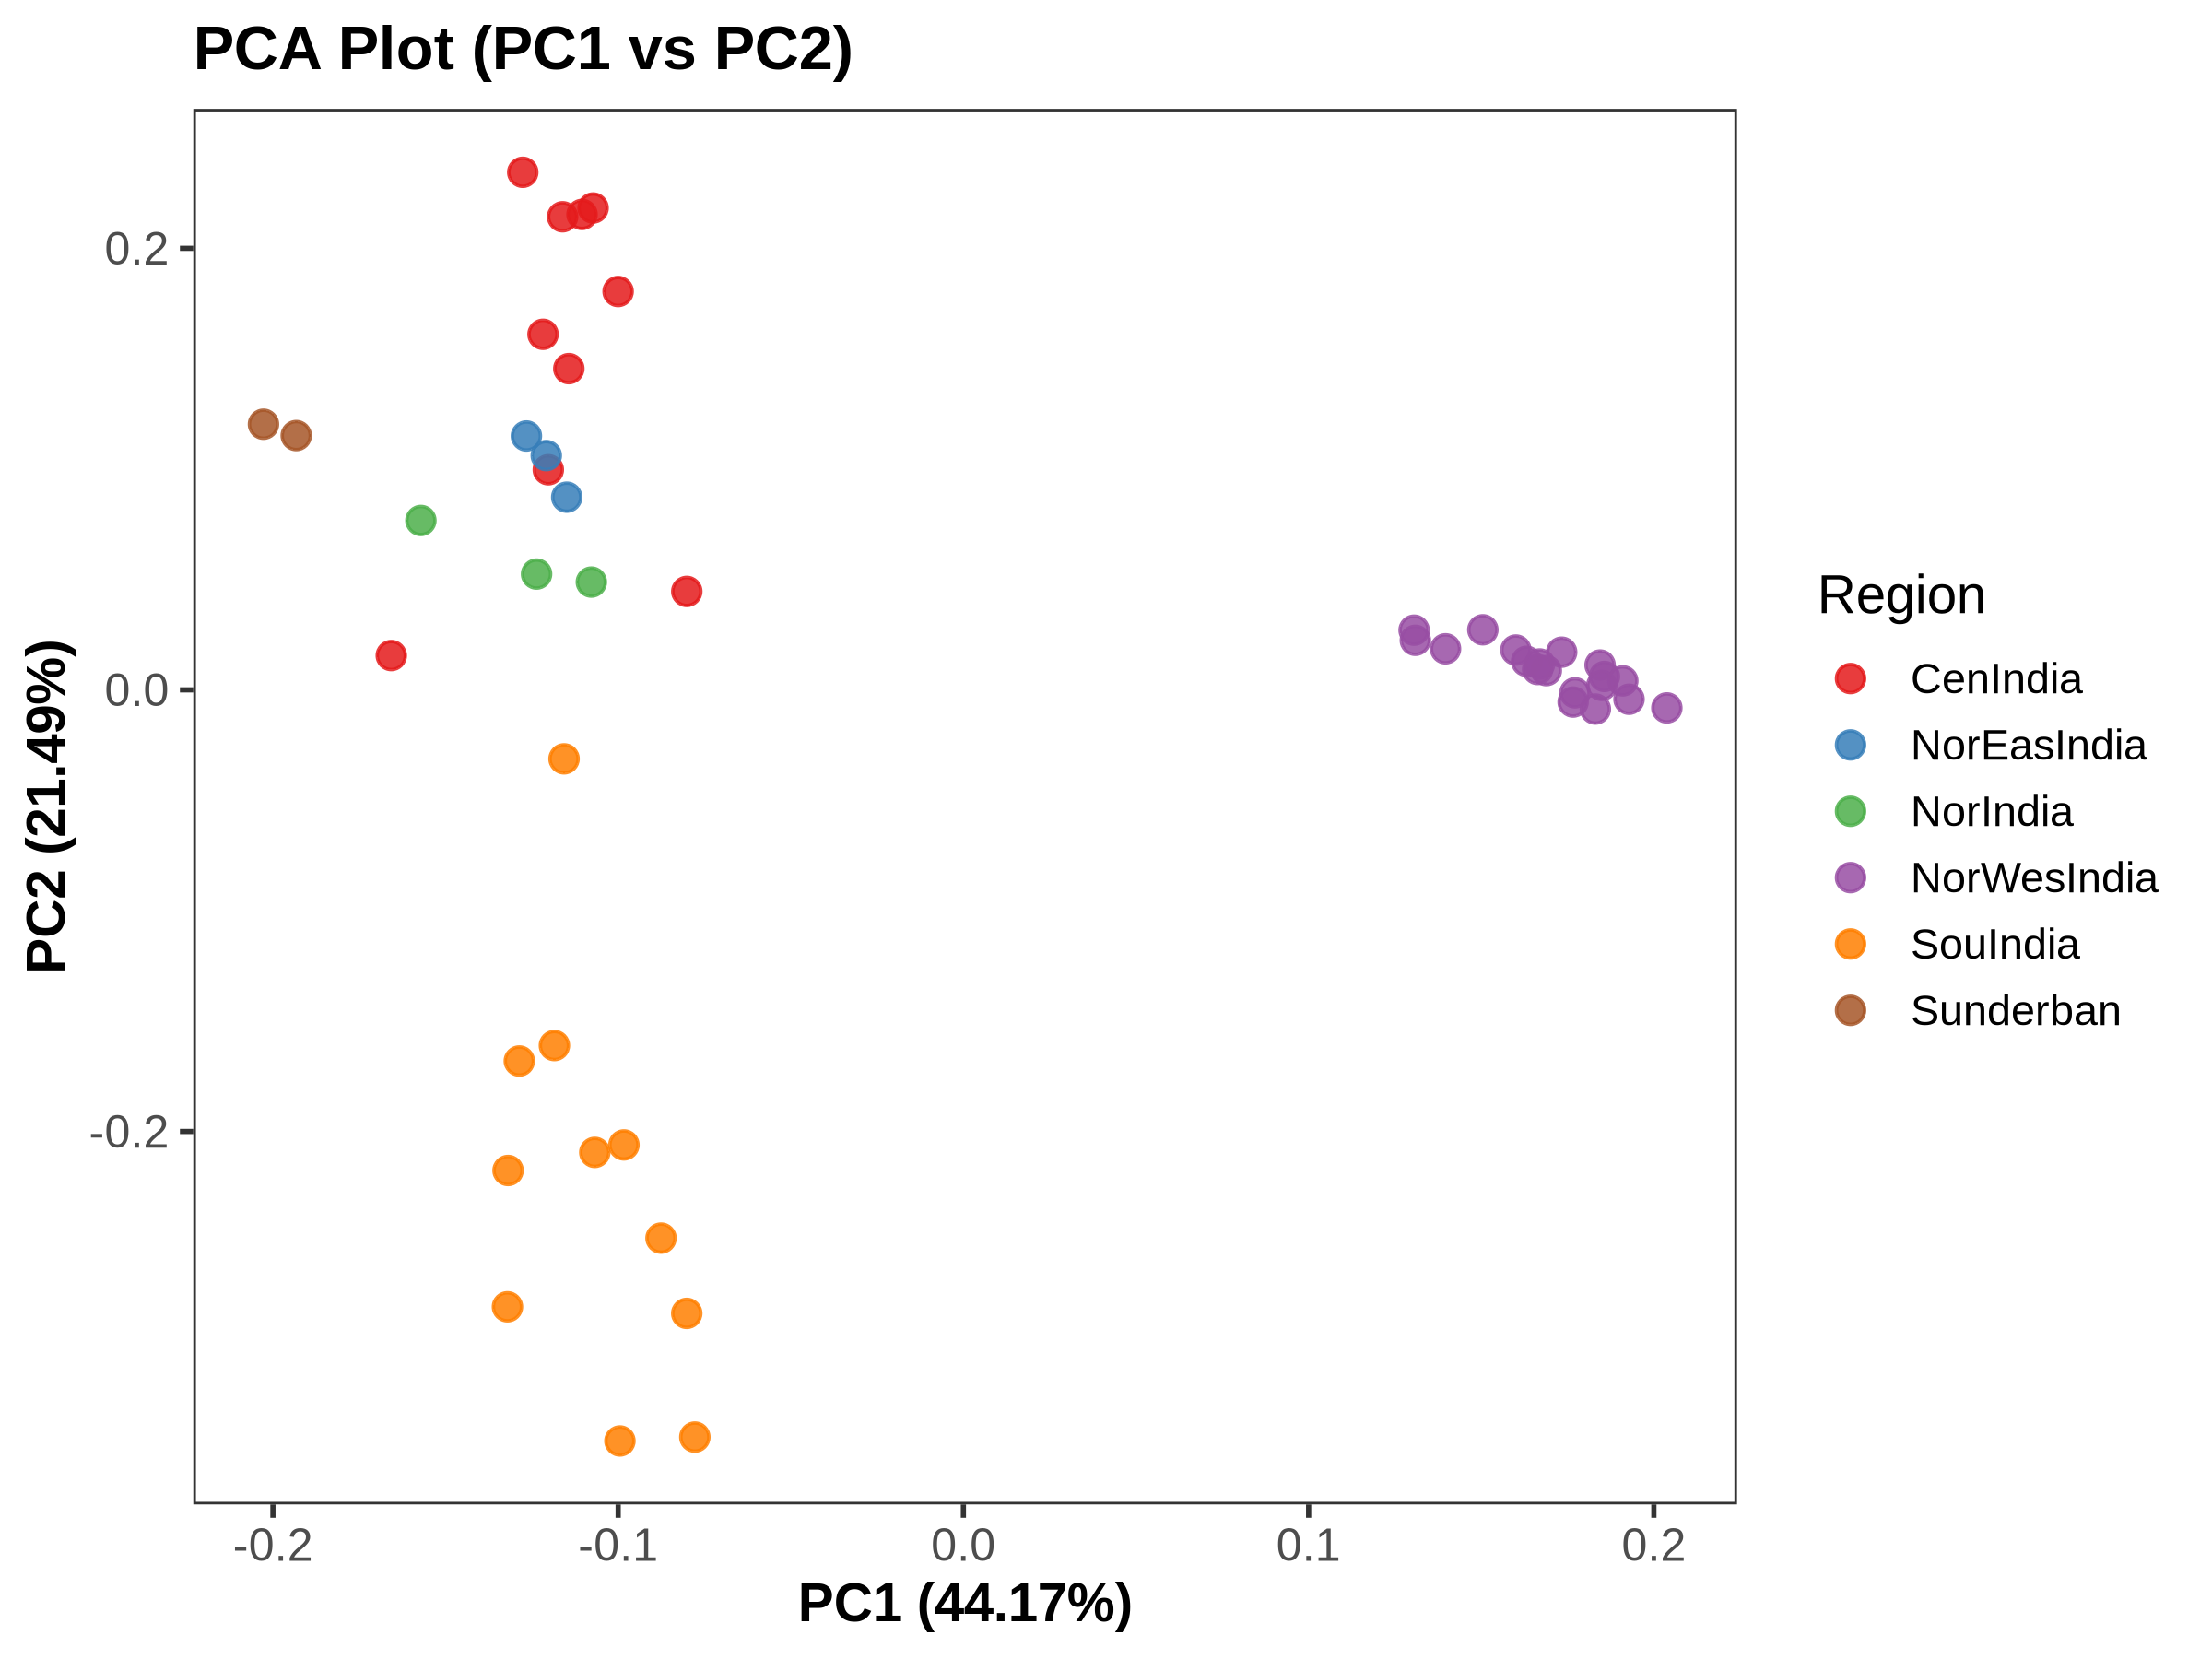

In [55]:
from IPython.display import Image, display

# Display the generated faceted PCA plot
display(Image('pca/pca_plot.png'))



#  **Understanding ADMIXTURE Analysis**

ADMIXTURE is one of the most widely used tools in population genetics for exploring **ancestral composition** within individuals or populations. It helps us answer questions such as:

* *How many genetic clusters (K) exist in the dataset?*
* *What proportion of each individual’s genome comes from different ancestral sources?*
* *How similar or different are populations based on shared ancestry?*

---

## **What Does ADMIXTURE Do?**

ADMIXTURE takes your **PLINK binary files** (`.bed`, `.bim`, `.fam`) and estimates **ancestry proportions** for each individual assuming a chosen number of clusters **K**.

For example:

* **K = 2** → You assume two ancestral populations
* **K = 3** → Three ancestral populations, and so on

It outputs two important files:

### **1️ `.Q` file**

* Contains *individual-level ancestry proportions*.
* Each row = one sample
* Each column = ancestry component (e.g., Cluster 1, Cluster 2, …)

### **2️ `.P` file**

* Contains *allele frequencies* associated with each cluster.
* Used mainly for deeper population structure interpretation.

---




##  **Prerequisite and Setup**

You must provide PLINK binary files:

```
XXX.bed
XXX.bim
XXX.fam
```

In this notebook:

1. We already have `.bed/.bim/.fam` files prepared.
2. We will test several values of **K** (e.g., 1 to 5).
3. We will record the **cross-validation (CV) error** for each K to identify the optimal model.
4. Finally, we will visualize the `.Q` file as a **barplot** showing ancestry proportions for each individual.

This helps us understand genetic clustering among our samples, and how much ancestral mixing has occurred.

---

# Script Overview

The command block below:

Activates the pop_gen Conda environment (which contains ADMIXTURE, PLINK, R, ggplot2)

Moves into the pca/ directory where the PLINK files are stored

Creates a new folder called admixture/ for storing all output files

Runs ADMIXTURE for K = 2, 3, and 4

Saves log files (logK.out) inside the admixture directory

Moves .Q and .P files into the same directory for easy access

In [25]:
%%bash
# Initialize Conda
source /usr/local/miniconda/etc/profile.d/conda.sh
conda activate pop_gen

cd pca

# Create admixture directory
mkdir -p admixture

PREFIX="machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB"

# Run ADMIXTURE for K=2..6 and save outputs
for K in {2..6}
do
    admixture ${PREFIX}.bed $K -j4 | tee admixture/log${K}.out
    mv ${PREFIX}.${K}.Q admixture/
    mv ${PREFIX}.${K}.P admixture/
done


****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Parallel execution requested.  Will use 4 threads.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 48x94503
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 0.174	Loglikelihood: -3.56271e+06	(delta): 2.84761e+06
2 (EM) 	Elapsed: 0.196	Loglikelihood: -3.


We will have to install the `tidyr` R package into the `pop_gen` conda environment, and then execute the `admixture_plot.R` script located in `pca/admixture/`. It is a dependency which is required for visualisation of the ADMIXTURE graph in the next step.

In [42]:
%%bash
# Initialize Conda for the current shell session
source /usr/local/miniconda/etc/profile.d/conda.sh

# Activate the conda environment
conda activate pop_gen

# Install r-tidyr and r-reshape2 from conda-forge channel
conda install -n pop_gen -c conda-forge r-tidyr r-reshape2 -y

Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: | / - \ done

## Package Plan ##

  environment location: /usr/local/miniconda/envs/pop_gen

  added / updated specs:
    - r-reshape2
    - r-tidyr


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    r-plyr-1.8.9               |    r45h3697838_3         769 KB  conda-forge
    r-rcpp-1.1.0               |    r45h3697838_1         2.0 MB  conda-forge
    r-reshape2-1.4.5           |    r45h3697838_0         125 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.9 MB

The following NEW packages will be INSTALLED:

  r-plyr             conda-forge/linux-64::r-plyr-1.8.9-r45h3697838_3 
  r-rcpp             conda-forge/linux-64::r-rcpp-1.1.0-r45h3697838_1 
  r-reshap



==> WARNING: A newer version of conda exists. <==
    current version: 25.9.1
    latest version: 25.11.0

Please update conda by running

    $ conda update -n base -c defaults conda




## Create ADMIXTURE Plotting R Script

Save the provided R code into a new script file named `admixture_plot.R` within the `pca/admixture` directory. This script will load necessary libraries, read the ADMIXTURE .Q file and the .fam file, process the data, and generate a grouped bar plot for K=3.


In [49]:
%%writefile pca/admixture/admixture_plot.R

# Load libraries
library(ggplot2)
library(tidyr)
library(dplyr)

# Define the base filename prefix used for PLINK and ADMIXTURE outputs
PREFIX <- "machali_Aligned_rangeWideMerge_strelka_update2_BENGAL_mac3_passOnly_biallelicOnly_noIndels_minMAF0Pt05_chr_E2_minDP3_minQ30_minGQ30_hwe_0.05_noIndels_missing_mm0.6_meandepth95percentile_noZSB"

# Define full paths for the .Q and .fam files for K=3
q_file_k3 <- paste0("pca/admixture/", PREFIX, ".3.Q")
fam_file <- paste0("pca/", PREFIX, ".fam")

# Check if files exist
if (!file.exists(q_file_k3)) stop("Cannot find .Q file for K=3: ", q_file_k3)
if (!file.exists(fam_file)) stop("Cannot find .fam file: ", fam_file)

# Read FAM file to get individual IDs and group information
fam <- read.table(fam_file, header = FALSE)
# Create unique individual IDs by combining FID (V1) and IID (V2)
unique_ind_ids <- paste(fam$V1, fam$V2, sep="_")

# Read ADMIXTURE Q file for K=3
q3 <- read.table(q_file_k3, header = FALSE)

# Check if the number of individuals matches
if (nrow(q3) != length(unique_ind_ids)) {
  stop("Number of individuals in Q file does not match .fam file.")
}

# Assign unique IDs to the Q matrix
q3$ID <- unique_ind_ids

# Assign column names for ancestry proportions
colnames(q3)[1:(ncol(q3)-1)] <- paste0("Anc", 1:(ncol(q3)-1))

# Extract group info from sample ID (assuming group is after the last underscore in the ID)
q3$Group <- gsub(".*_([^_]+)$", "\\1", q3$ID) # Extracts the last part after an underscore

# Reshape data for ggplot
q3_long <- q3 %>%
  pivot_longer(
    cols = starts_with("Anc"),
    names_to = "Ancestry",
    values_to = "Proportion"
  )

# Sort individuals by group and then by ID for consistent plotting
q3_long <- q3_long %>%
  arrange(Group, ID) %>%
  mutate(ID = factor(ID, levels = unique(ID))) # Ensure ID is a factor with sorted levels

# Plot
p <- ggplot(q3_long, aes(x = ID, y = Proportion, fill = Ancestry)) +
  geom_bar(stat = "identity", width = 1) +
  facet_grid(~Group, scales = "free_x", space = "free_x") + # Facet by group
  theme_minimal() +
  labs(x = "Individuals", y = "Ancestry Proportion", title = "ADMIXTURE Plot (K=3)") +
  theme(
    axis.text.x = element_blank(), # Hide x-axis text as it would be too crowded
    axis.ticks.x = element_blank(),
    panel.spacing = unit(0.5, "lines"),
    strip.text.x = element_text(angle = 0, face = "bold"), # Keep group labels readable
    legend.position = "right"
  ) +
  scale_fill_brewer(palette = "Set1") # Use a colorblind-friendly palette

# Save as PNG to the correct directory
ggsave("pca/admixture/admixture_K3_grouped.png", plot = p, width = 12, height = 6, dpi = 300)

message("ADMIXTURE plot for K=3 saved as pca/admixture/admixture_K3_grouped.png")


Overwriting pca/admixture/admixture_plot.R


## Execute ADMIXTURE Plotting R Script

Run the newly created `admixture_plot.R` script using `Rscript` within the activated `pop_gen` conda environment. This will generate the ADMIXTURE plot as a PNG image.


In [50]:
%%bash
# Initialize Conda for the current shell session
source /usr/local/miniconda/etc/profile.d/conda.sh

# Activate the conda environment with R and tidyr
conda activate pop_gen

# Execute the R script to generate ADMIXTURE plots
Rscript pca/admixture/admixture_plot.R


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

ADMIXTURE plot for K=3 saved as pca/admixture/admixture_K3_grouped.png


To visualise the graph, we can run following command:

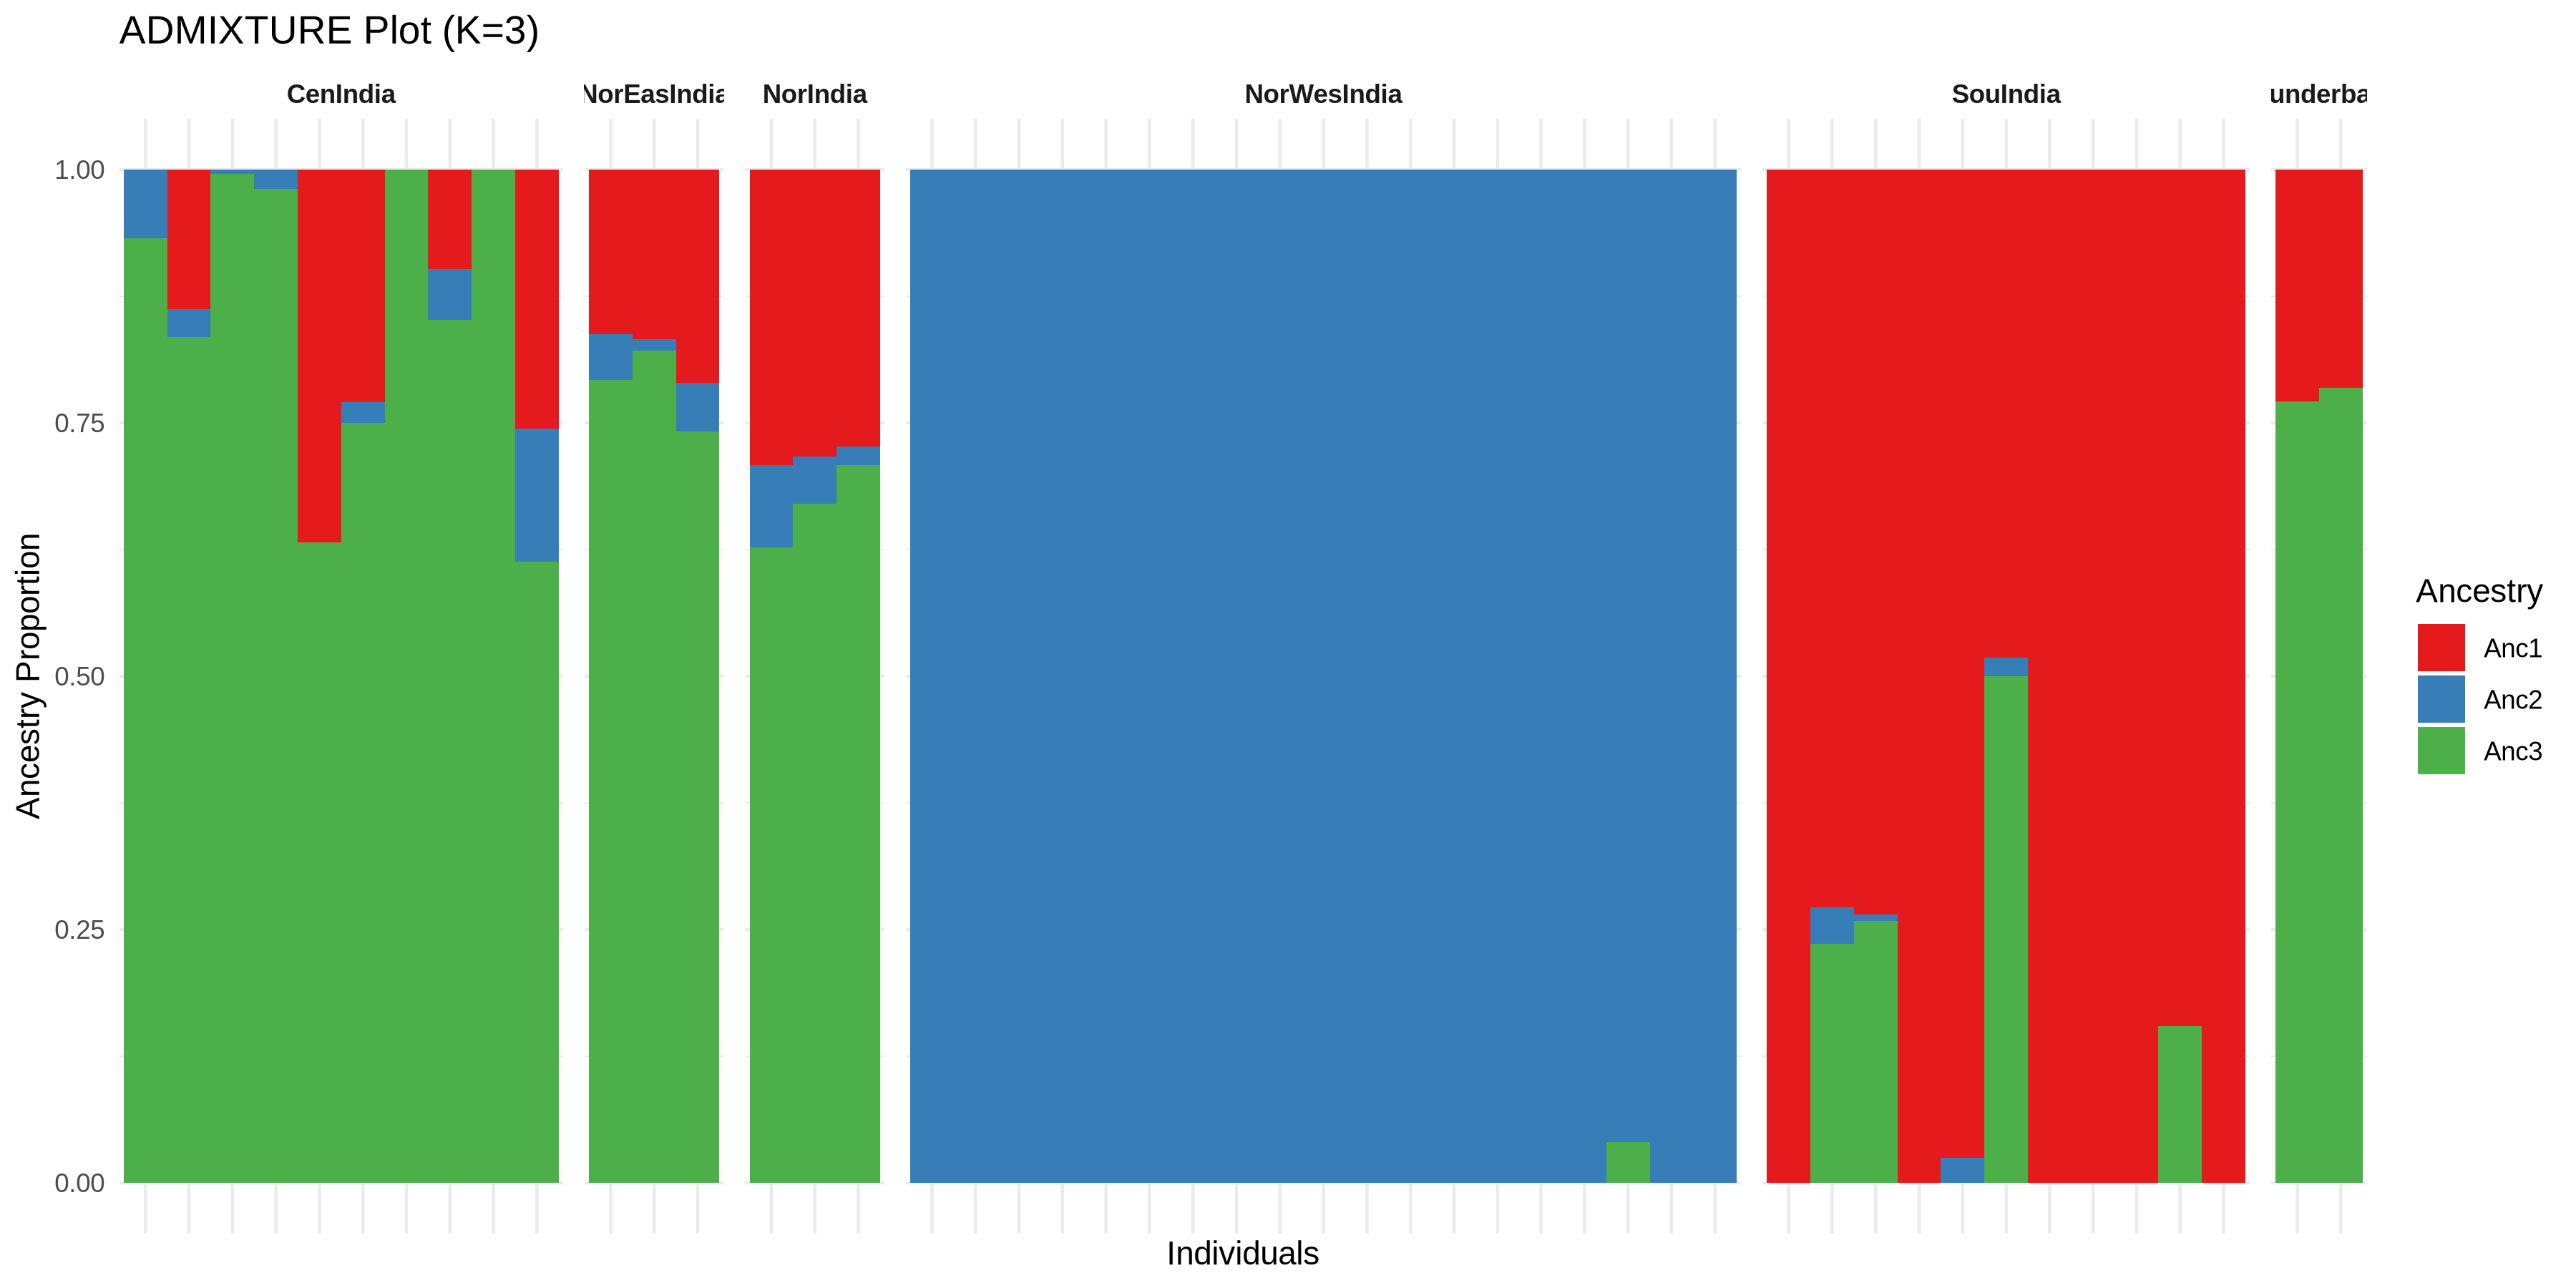

In [52]:
from IPython.display import Image, display

# Display the generated faceted ADMIXTURE plot
display(Image('pca/admixture/admixture_K3_grouped.png'))